# SLTimer Example Analysis of TDC2 Data

This notebook shows you how to find the estimation of a lens time delay from TDC2 light curve data using the `PyCS` code. For a detailed tutorial through the `PyCS` code, please visit this [address.](https://github.com/DarkEnergyScienceCollaboration/SLTimer/blob/master/notebooks/PyCS_Tutorial.ipynb)

First, we'll import `SLTimer`, as well as a few other important commands. 

In [1]:
from __future__ import print_function
import os, urllib, numpy as np
%matplotlib inline

import sys
sys.path.append('../python')
import desc.sltimer

%load_ext autoreload
%autoreload 2

## Data Munging

Now, let's start a timer object, and download some data to use. The output should show 1006 imported points if we are using the correct `tdc2-gateway-1.txt` file.

In [2]:
timer = desc.sltimer.SLTimer()

In [6]:
url = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt"
timer.download(url, and_read=True, format='tdc2')

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/A] with 1006 points imported (0 of them masked).
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/B] with 1006 points imported (0 of them masked).


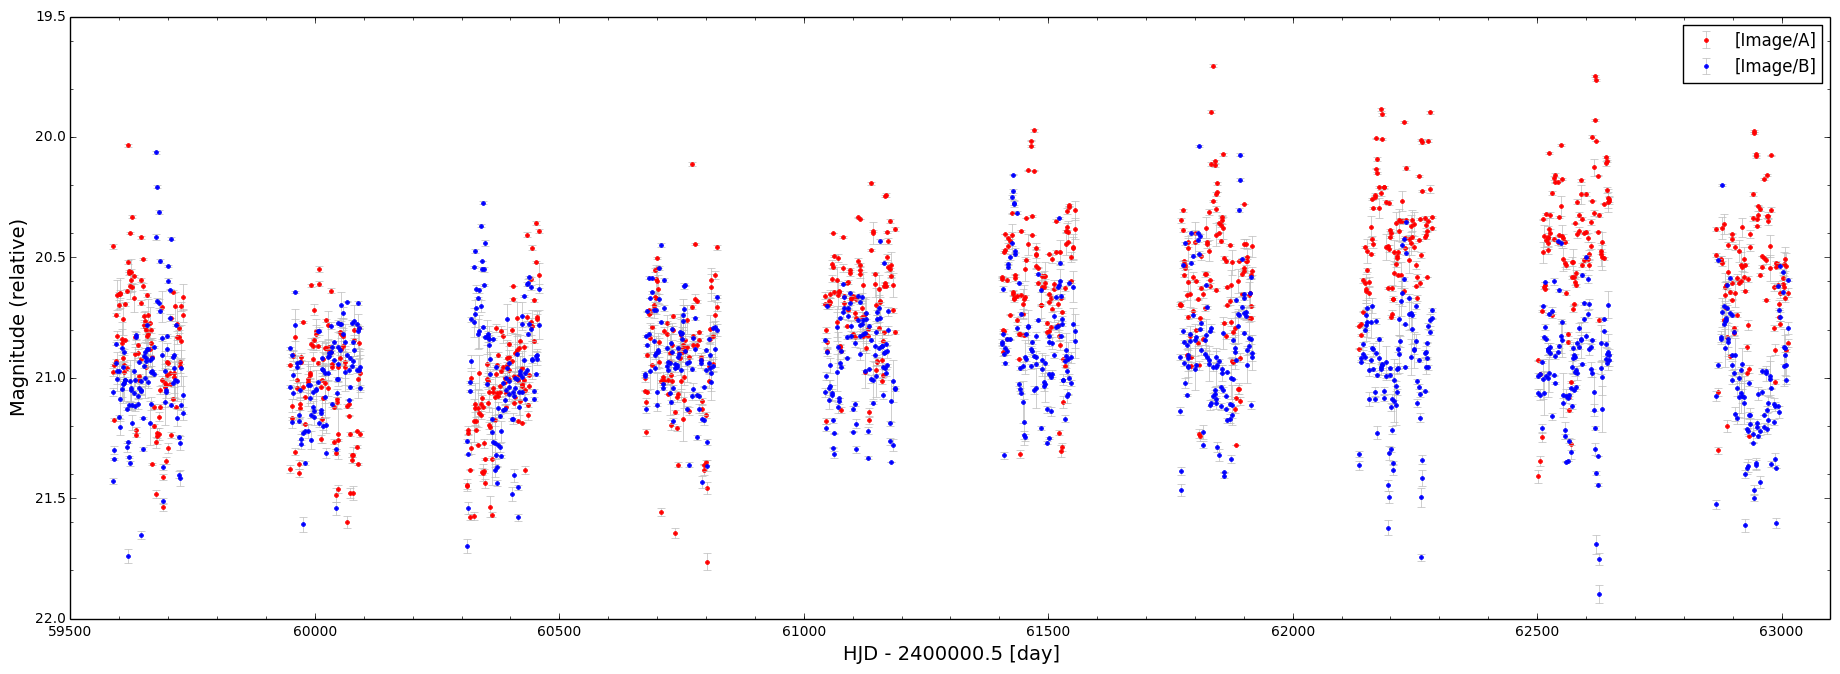

In [7]:
timer.display_light_curves(jdrange=(59500,63100))

We're now ready to analyze this data. We'll start with it as-is, and then later try "whitening" it.

## Spline Modeling

The following lines will run an entire free-knot spline technique on your data with a complete error analysis using the `TDC2` method. Below, you can specify how the time delays will be analyzed. The default is listed below according to the `PyCS` tutorial. See the bottom of the page for alternate methods. 

In [5]:
timer.estimate_time_delays(method='pycs',microlensing='spline',agn='spline',error=None)

You are using the pycs method.
Starting opt_rough on initial delays :
AB   +0.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/21~|
Working on the spline ML of [Image/B](0.000,-0.258,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB   +3.00    (Iteration  1, r2 = 16453487.4)
AB   +4.00    (Iteration  2, r2 = 16316228.8)
AB   +5.00    (Iteration  3, r2 = 16217734.8)
AB   +6.00    (Iteration  4, r2 = 16132635.0)
AB   +7.00    (Iteration  5, r2 = 16075641.6)
Rough time shifts done :
AB   +7.00
Starting opt_rough on initial delays :
AB   +7.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A](-1.000,0.000,0)|~3/u/21~|
Working on the spline ML of [Image/B](6.000,-0.258,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB   +7.00    (Iteration  1, r2 = 13418014.8)
AB   +7.00    (Iteration  2, r2 = 13233427.0)
AB   +7.00    (Iteration  3, r2 = 13188222.5)
AB   +7.00    (Iteration  4, r2 = 13184929.8)
A

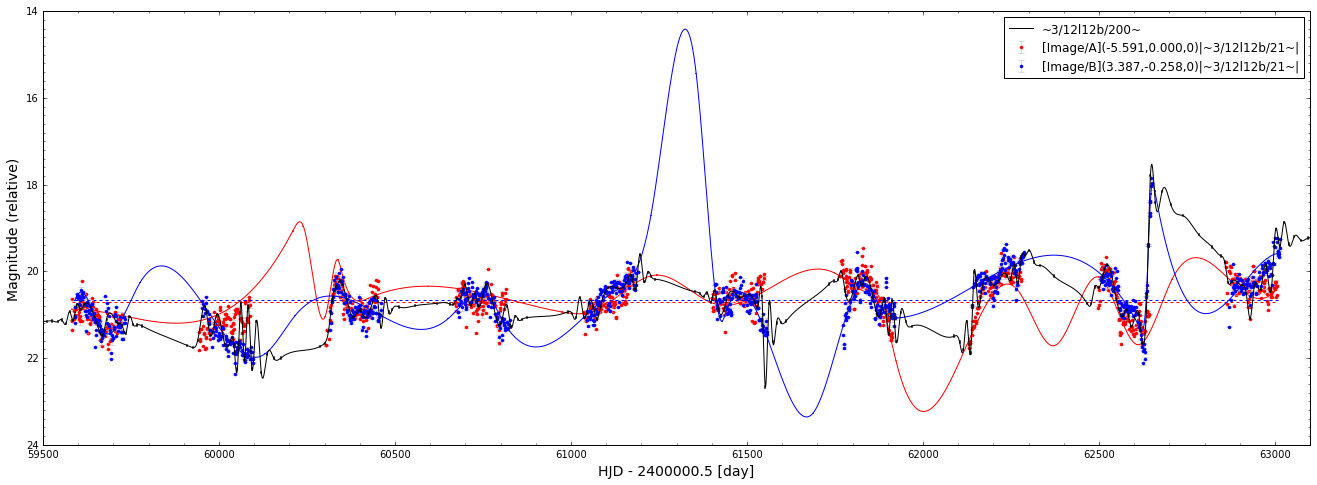

In [6]:
timer.display_light_curves(jdrange=(59500,63100))

While the time delays have been estimated, we can see that the different images' light curves are not shifted and microlensing-corrected terribly well. 

In [7]:
# timer.estimate_uncertainties(n=3,npkl=5)

## Whitening the Light Curves

In the above analysis we ignored the fact that the magnitudes were measured in 6 different filters, and just used them all as if they were from the same filter. By offsetting the light curves to a common mean, we should get a set of points that look more like they were taken in one filter. This process is known as "whitening."

In [8]:
wtimer = desc.sltimer.SLTimer()
wtimer.download(url, and_read=True, format='tdc2')

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-1.txt
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/A] with 1006 points imported (0 of them masked).
Checking header of "tdc2-gateway-1.txt"...
Reading "tdc2-gateway-1.txt"...
[Image/B] with 1006 points imported (0 of them masked).


In [9]:
wtimer.whiten()

whiten: before whitening, means = {'A': 20.709889147670172, 'B': 20.942986859620213}
whiten: before whitening, scatters = {'A': 0.33118712223926866, 'B': 0.24520912405242917}
whiten: detected bands: ['g' 'i' 'r' 'u' 'y' 'z']
whiten: after whitening, means = {'A': 20.709889147670172, 'B': 20.942986859620213}
whiten: after whitening, scatters = {'A': 0.32647791567919016, 'B': 0.24278378000885809}


The change brought about by whitening is pretty subtle: the means of each image's light curve stay the same (by design), but the scatter in each image's light curve is somewhat reduced. 

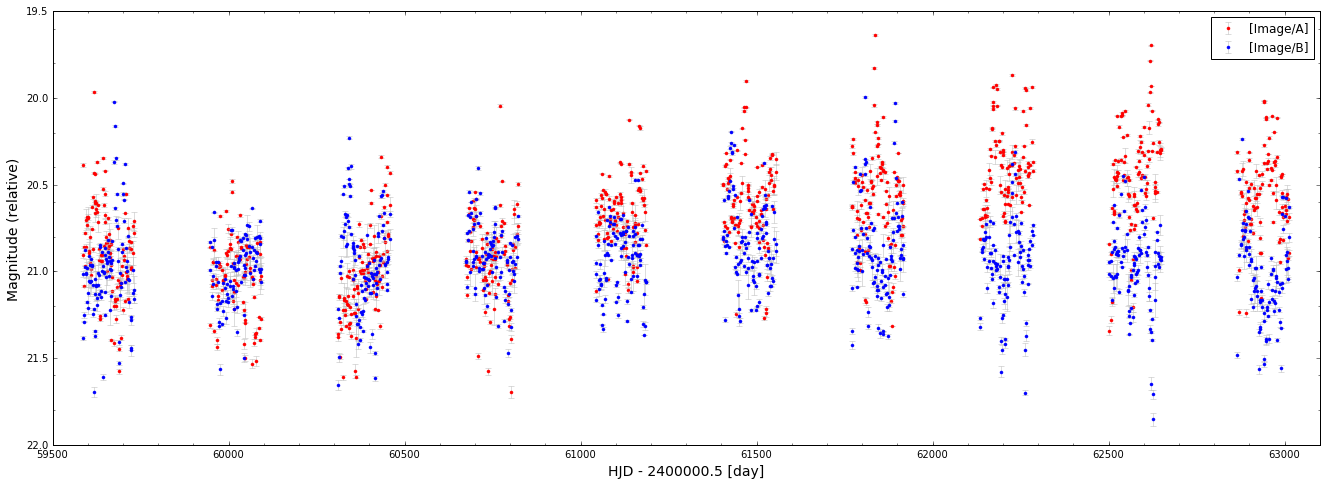

In [10]:
wtimer.display_light_curves(jdrange=(59500,63100))

In [11]:
wtimer.estimate_time_delays(method='pycs',microlensing='spline',agn='spline',error=None)

You are using the pycs method.
Starting opt_rough on initial delays :
AB   +0.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/21~|
Working on the spline ML of [Image/B](0.000,-0.249,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB   +3.00    (Iteration  1, r2 = 16305717.6)
AB   +5.00    (Iteration  2, r2 = 16035479.6)
AB   +6.00    (Iteration  3, r2 = 15958057.1)
AB   +7.00    (Iteration  4, r2 = 15906297.1)
AB   +8.00    (Iteration  5, r2 = 15865567.7)
Rough time shifts done :
AB   +8.00
Starting opt_rough on initial delays :
AB   +8.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A](-2.000,0.000,0)|~3/u/21~|
Working on the spline ML of [Image/B](6.000,-0.249,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB   +8.00    (Iteration  1, r2 = 13273613.4)
AB   +8.00    (Iteration  2, r2 = 13001173.4)
AB   +8.00    (Iteration  3, r2 = 12922658.0)
AB   +8.00    (Iteration  4, r2 = 12910413.3)
A

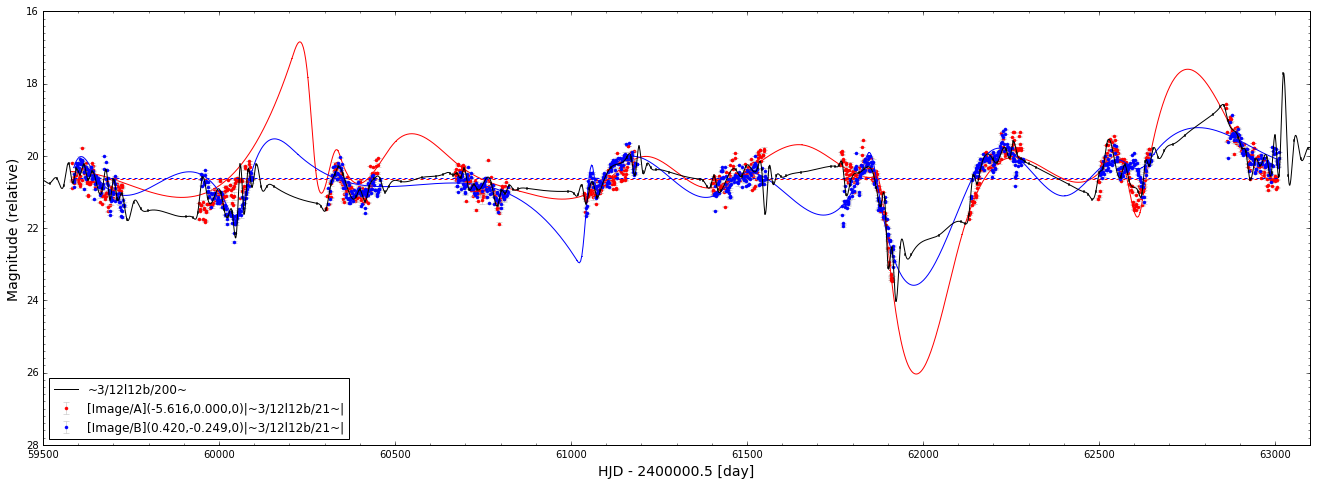

In [12]:
wtimer.display_light_curves(jdrange=(59500,63100))

How does the plot compare? Note that the y axis scale is different: the shifted light curves seem to match up better now.

Now let's look at the estimated time delays - by how much do they differ, between the unwhitened and whitened data?

#### Whitened:

In [13]:
wtimer.report_time_delays()

Time Delays:
AB   +6.04


#### Unwhitened:

In [14]:
timer.report_time_delays()

Time Delays:
AB   +8.98


#### Truth:

In [5]:
truthurl = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/gatewaytruth.txt"
truthfile = truthurl.split('/')[-1]
if not os.path.isfile(truthfile):
    urllib.urlretrieve(truthurl, truthfile)
d = np.loadtxt(truthfile).transpose()
truth = d[0]
print("True Time Delays:", truth)

True Time Delays: [  55.37   39.1    46.7    24.06   97.19   52.2    50.72  111.49  117.69
   40.56]


## Conclusions

The above demo shows that:

* We can read in and analyze multi-filter TDC2 data with `PyCS`
* Whitening the data may lead to improved estimates, but more tests will be needed
* It's easy to get stuck at a local maximum in the time delay likelihood function

Our next step is to experiment with re-initializing the fit to avoid getting stuck at local maxima.